# Question 8 

Practice training a deep neural network on the CIFAR10 image dataset:

1. Build a DNN with 20 hidden layers of 100 neurons each (that’s too many, but
it’s the point of this exercise). Use He initialization and the ELU activation
function.

2. Using Nadam optimization and early stopping, train the network on the
CIFAR10 dataset. You can load it with keras.datasets.cifar10.load_data(). The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you’ll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model’s architecture or hyperparameters.

3. Now try adding Batch Normalization and compare the learning curves: Is it
converging faster than before? Does it produce a better model? How does it
affect training speed?

4. Try replacing Batch Normalization with SELU, and make the necessary adjustements to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).

5. Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC Dropout.

6. Retrain your model using 1cycle scheduling and see if it improves training
speed and model accuracy.

Solutions to these exercises are available in Appendix A.


## Imports

In [ ]:
import tensorflow as tf  
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functools import partial
import os
from sklearn.model_selection import learning_curve
import math

## Load the dataset

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

## Take a look at the CIFAR10 image dataset

In [ ]:
# 32x32 pixel, 3 color channels (red, green, blue) -> renkli resimler
print("Shape of X_train: ", X_train_full.shape) # 50000 training instances
print("Shape of y_train: ", y_train_full.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape) # 10000 test instances

In [ ]:
y_train_full

In [ ]:
# number of classes - 10 classes
np.unique(y_train_full) 

Labels : 
* airplane - 0
* automobile - 1
* bird - 2
* cat - 3
* deer - 4
* dog - 5
* frog - 6
* horse -7
* ship - 8
* truck - 9

In [ ]:
pd.DataFrame(y_train_full).value_counts() # each class has 5000 images

In [ ]:
label = "Label: " + str(y_train_full[0][0])
plt.xlabel(label)
plt.imshow(X_train_full[0], aspect = 'auto')

In [ ]:
#examine data
img_classes=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [ ]:
# visualize data by plotting images
fig, ax = plt.subplots(5, 5, figsize = (20,20))
k = 0
 
for i in range(5):
    for j in range(5):
        # hide x any y ticks
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

        label = "Label: " + str(img_classes[y_train_full[k][0]])
        ax[i][j].set_xlabel(label, fontsize = 20)
        ax[i][j].imshow(X_train_full[k], aspect='auto')
        k += 1


# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=1.5,
                    wspace=0.4,
                    hspace=0.4)

plt.show()

In [ ]:
# Splitting the dataset into training and validation dataset
# because we want to use early stopping
X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000] # first 5000 images
y_valid = y_train_full[:5000]

In [ ]:
print("Shape of X_train: ", X_train.shape) # 45000 training instances
print("Shape of y_train: ", y_train.shape)
print("Shape of X_valid: ", X_valid.shape)
print("Shape of y_valid: ", y_valid.shape) # 5000 validation instances

## Build a DNN


a. Build a DNN with 20 hidden layers of 100 neurons each (that’s too many, but
it’s the point of this exercise). Use He initialization and the ELU activation
function.


In [ ]:
# avoid writing the same 20 layers over and over again 
RegularizedDense = partial(keras.layers.Dense,
activation="elu",
kernel_initializer="he_normal")

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3])) # input layer

for _ in range(20):
    model.add(RegularizedDense(100)) # hidden layers

model.add(keras.layers.Dense(10, activation="softmax")) # output layer, 10 classes

In [ ]:
model.summary()

## Nadam Optimization and Early Stopping

b. Using Nadam optimization and early stopping, train the network on the
CIFAR10 dataset. You can load it with keras.datasets.cifar10.load_data(). The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you’ll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model’s architecture or hyperparameters.

In [ ]:
optimizer = keras.optimizers.Nadam(learning_rate=5e-5) # 0.00005
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
# early stopping
# patience : Number of epochs with no improvement after which training will be stopped.
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)

In [ ]:
# checkpoint, rollback to best model
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_model.h5", save_best_only=True)

In [ ]:
# for tensorboard
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [ ]:
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [ ]:
# 1407 = total number of batches processed in each epoch
model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

In [ ]:
model.history.history

In [ ]:
history_dict = model.history.history
train_loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

In [ ]:
# learning curve
# Plot accuracy per iteration
plt.plot(train_accuracy, label='Training Accuracy', color='red')
plt.plot(val_accuracy, label='Validation Accuracy', color='blue')
plt.legend()

In [ ]:
# learning curve
# Plot accuracy per iteration
plt.plot(train_loss_values, label='Training Loss', color='red')
plt.plot(val_loss_values, label='Validation Loss', color='blue')
plt.legend()

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=./my_cifar10_logs/run_001 --port=6029

In [ ]:
model = keras.models.load_model("my_cifar10_model.h5") # rollbackt to best model
model.evaluate(X_valid, y_valid)

The model with the lowest validation loss gets about 46.08% accuracy and     1.527 loss on the validation set. It took 36(55-patience(20)) epochs to reach the lowest validation loss, with roughly 27 seconds per epoch.

* val_loss: 1.5271 - val_accuracy: 0.4608

## Batch Normalization and Learning curves:

c. Now try adding Batch Normalization and compare the learning curves: Is it
converging faster than before? Does it produce a better model? How does it
affect training speed?

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model.add(keras.layers.BatchNormalization()) # first layer in the model, StandardScaler effect

In [ ]:
"""
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(keras.layers.BatchNormalization()) # after every dense layer, before the activation function
    model.add(keras.layers.Activation("elu"))
model.add(keras.layers.Dense(10, activation="softmax"))

"""
# zero centers and normalizes each input, then scales and shifts the result
# using two new parameter vectors per layer 
# before or after the activation function of each hidden layer
# the operation lets the model learn the optimal
# scale and mean of each of the layer’s inputs.
# not used after output layer

for _ in range(20):
    model.add(RegularizedDense(100)) # hidden layers
    model.add(keras.layers.BatchNormalization()) # # after every dense layer, after the activation function

model.add(keras.layers.Dense(10, activation="softmax")) # output layer, 10 classes

In [ ]:
model.summary()

In [ ]:
optimizer = keras.optimizers.Nadam(learning_rate=5e-4) # 0.0005, learning_rate i arrtır
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_bn_model.h5", save_best_only=True)
#model file name to my_cifar10_bn_model.h5. (bn yoktu öncekinde)

In [ ]:
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_bn_{:03d}".format(run_index))
run_logdir
# renamed the run directories to run_bn_* (bn yoktu öncekinde)

In [ ]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [ ]:
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [ ]:
model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

In [ ]:
%tensorboard --logdir=./my_cifar10_logs --port=6000

In [ ]:
# with bn
history_dict_bn = model.history.history
train_loss_values = history_dict_bn['loss']
val_loss_values = history_dict_bn['val_loss']
train_accuracy = history_dict_bn['accuracy']
val_accuracy = history_dict_bn['val_accuracy']

In [ ]:
# learning curve
# Plot accuracy per iteration
plt.plot(train_accuracy, label='Training Accuracy', color='red')
plt.plot(val_accuracy, label='Validation Accuracy', color='blue')
plt.title("Accuracy With Batch Normalization")
plt.legend()

In [ ]:
# learning curve
# Plot accuracy per iteration
plt.plot(train_loss_values, label='Training Loss', color='red')
plt.plot(val_loss_values, label='Validation Loss', color='blue')
plt.title("Loss With Batch Normalization")
plt.legend()

In [ ]:
model = keras.models.load_model("my_cifar10_bn_model.h5") # Epoch 17 da en iyi model bulundu.patience 20 olduğu için 20 adım daha devam etti.
model.evaluate(X_valid, y_valid)

* Is the model converging faster than before? Much faster! The previous model took 36 epochs to reach the lowest validation loss, while the new model achieved that same loss in just 5 epochs. The BN layers stabilized training and allowed us to use a much larger learning rate, so convergence was faster.

* Does BN produce a better model? Yes! The final model is also much better, with 54.22% accuracy instead of 46.08%. It's still not a very good model, but at least it's much better than before.

* How does BN affect training speed? Although the model converged much faster, each epoch took about 40s instead of 26s, because of the extra computations required by the BN layers. But overall the training time (wall time) was shortened significantly!

## SeLU

d. Try replacing Batch Normalization with SELU, and make the necessary adjustements to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# avoid writing the same 20 layers over and over again 
NormalizedDense = partial(keras.layers.Dense,
activation="selu",
kernel_initializer="lecun_normal")

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3])) # input layer

for _ in range(20):
    model.add(NormalizedDense(100)) # hidden layers

model.add(keras.layers.Dense(10, activation="softmax")) # output layer, 10 classes

In [ ]:
model.summary()

In [ ]:
optimizer = keras.optimizers.Nadam(learning_rate=7e-4) # 0.0007, learning rate i daha da büyüt
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_selu_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_selu_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [ ]:
# Scale
X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

In [ ]:
model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

In [ ]:
# with selu
history_dict_selu = model.history.history
train_loss_values = history_dict_selu['loss']
val_loss_values = history_dict_selu['val_loss']
train_accuracy = history_dict_selu['accuracy']
val_accuracy = history_dict_selu['val_accuracy']

In [ ]:
history_dict_selu

In [ ]:
# learning curve
# Plot accuracy per iteration
plt.plot(train_accuracy, label='Training Accuracy', color='red')
plt.plot(val_accuracy, label='Validation Accuracy', color='blue')
plt.title("Accuracy With Selu")
plt.legend()

In [ ]:
# learning curve
# Plot accuracy per iteration
plt.plot(train_loss_values, label='Training Loss', color='red')
plt.plot(val_loss_values, label='Validation Loss', color='blue')
plt.title("Loss With Selu")
plt.legend()

In [ ]:
%tensorboard --logdir=./my_cifar10_logs --port=6007

In [ ]:
model = keras.models.load_model("my_cifar10_selu_model.h5") # Epoch 10 da en iyi model bulundu.
# 8 epoch ile de ilk şıkta 37 Epoch da bulunan modeli geçti.
model.evaluate(X_valid_scaled, y_valid)

* We get 50.3% accuracy, which is not much better than the original model (46.08%), and not as good as the model using batch normalization (54.22%). However, convergence was almost as fast as with the BN model, plus each epoch took only 22 seconds. So it's by far the fastest model to train so far.

## Regularize the model 

e. Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC Dropout.

### With Alpha Dropout

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3])) # input layer

for _ in range(20):
    model.add(NormalizedDense(100)) # hidden layers

model.add(keras.layers.AlphaDropout(rate=0.1))
# Alpha Dropout is a Dropout that keeps mean and variance of inputs to their 
# original values, in order to ensure the self-normalizing property even after 
# this dropout. Alpha Dropout fits well to Scaled Exponential Linear Units by 
# randomly setting activations to the negative saturation value.
model.add(keras.layers.Dense(10, activation="softmax")) # output layer, 10 classes

In [ ]:
model.summary()

In [ ]:
optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_alpha_dropout_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_alpha_dropout_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [ ]:
# Scaling
X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

In [ ]:
model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

In [ ]:
model = keras.models.load_model("my_cifar10_alpha_dropout_model.h5") # Epoch 6' de bulmuş en iyi modelini en az loss olan
model.evaluate(X_valid_scaled, y_valid)

* The model reaches 47.50% accuracy on the validation set. That's slightly better than without dropout (46.08%). 

In [ ]:
%tensorboard --logdir=./my_cifar10_logs --port=6007

### With MC Dropout

In [ ]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
              # setting training=True to ensure that
              # the Dropout layer is active, and stack the predictions.
              # apply dropout at test time
              return super().call(inputs, training=True)

In [ ]:
# Now let's create a new model, identical to the one we just trained (with the same weights),
# but with MCAlphaDropout dropout layers instead of AlphaDropout layers:

mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers 
    # trained modelimizde dropout layerlarını mc ile değiştiriyor sadece tekrar eğitmiyor
])

In [ ]:
#  The first will run the model many times (10 by default) and 
#  it will return the mean predicted class probabilities
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)] # shape=(10, 5000, 10)
    return np.mean(Y_probas, axis=0) # columnn wise, 5000x10 bir prediciton döndericek 
    
    """
First Prediciton for first instance :    [0.1 .... 0.5] - toplamı 1 edicek olasılıklar 10 sınıf için
First Prediciton for second instance :   [0.056 .... 0.9] - toplamı 1 edicek olasılıklar 10 sınıf için
her prediciton shape : 5000x10 (rowlar instance, columnlar class)

    """


# chooses the highest predicted probability to pick the most likely class. 
# This will use these mean probabilities to predict the 
# most likely class for each instance:
def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    print(pd.DataFrame(Y_probas))
    return np.argmax(Y_probas, axis=1)  # Returns the indices of the maximum values along an axis for row

    """
    5000 instances : 

    [9] - belongs to the class truck
    [1] - belongs to thr class automobile
    ...

    """

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled) # inference, validation set

In [ ]:
y_pred

In [ ]:
y_pred.shape # 5000 intances per inferece 1 prediction

In [ ]:
accuracy = np.mean(y_pred == y_valid[:, 0])
accuracy

* We get no significant accuracy improvement in this case. We're at 47.7% accuracy on validation set. So the best model we got in this exercise is the Batch Normalization model.

## Retraining

f. Retrain your model using 1cycle scheduling and see if it improves training
speed and model accuracy.

- 1cycle scheduling
    
    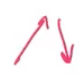
    - 2018, en iyi çalışan mekanizmalardan
    - küçük büyük sonra tekrar küçük
    - eğitimi hızlandırıyor, accuracy yükseliyor, error rate azalıyor

* It starts by increasing the initial learning rate η0, growing linearly up to η1
halfway through training. 

* Then it decreases the learning rate linearly down to η0 again during the second half of training, finishing the last few epochs by dropping the rate down by several orders of magnitude (still linearly). 

* The maximum learning rate η1 is chosen using the same approach we used to find the optimal learning rate, and the initial learning rate η0
is chosen to be roughly 10 times lower. 

* When using a momentum, we start with a high momentum first (e.g., 0.95), then drop it down to a lower momentum during the first half of training(e.g., down to 0.85, linearly), and then bring it back up to the maximum value (e.g., 0.95) during the second half of training, finishing the last few epochs with that maximum value.

In [ ]:
# i.e., by growing the learning rate exponentially, plotting 
# the loss, and finding the point where the loss shoots up
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
  
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs): # on_batch_*, on_train_end, on_epoch_begin
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

In [ ]:
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs # bir epoch un tamamlanması için gerekli adım sayısını bulup epoch ile çarpıyor
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    print("Factor: ", factor)

    init_lr = K.get_value(model.optimizer.learning_rate)
    print("Initial Learning Rate: ", init_lr)

    K.set_value(model.optimizer.learning_rate, min_rate) # 10^-5 ile başlıyor
    exp_lr = ExponentialLearningRate(factor) # her 32 instancedan sonra faktör ile  çarpılıyor
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    
    # 1 epoch sonra eğitim bitince, optimizer ın learning rate e eşitliyor
    K.set_value(model.optimizer.learning_rate, init_lr) # modeli eski haline geri getiriyo
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses
# optimal learning rate i bulmak için

In [ ]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3])) # input layer

for _ in range(20):
    model.add(NormalizedDense(100)) # hidden layers

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax")) # output layer, 10 classes

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses) # 0.5 - best candidate for n1 aka max_rate

In [ ]:
rates

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10 # chosen to be roughly 10 times lower. 
        self.last_iterations = last_iterations or iterations // 10 + 1 # floor division, 500, decay phase
        self.half_iteration = (iterations - self.last_iterations) // 2 # without decay phase, 2500
        self.last_rate = last_rate or self.start_rate / 1000 # at the end
        self.iteration = 0
        self.rates = []

    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1) / (iter2 - iter1) + rate1)
        
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration: # 0-2500, max_rate e çık 
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration: # 2500-5000
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else: #decay phase, 5000-5500, last_rate e düş
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            
        self.rates.append(rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3])) # input layer

for _ in range(20):
    model.add(NormalizedDense(100)) # hidden layers

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax")) # output layer, 10 classes

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=1e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_1cycle_model.h5", save_best_only=True)

In [ ]:
n_epochs = 15
onecycle = OneCycleScheduler(math.ceil(len(X_train_scaled) / batch_size) * n_epochs, max_rate=0.05) # iteration and max_rate
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle, model_checkpoint_cb])

In [ ]:
onecycle.rates

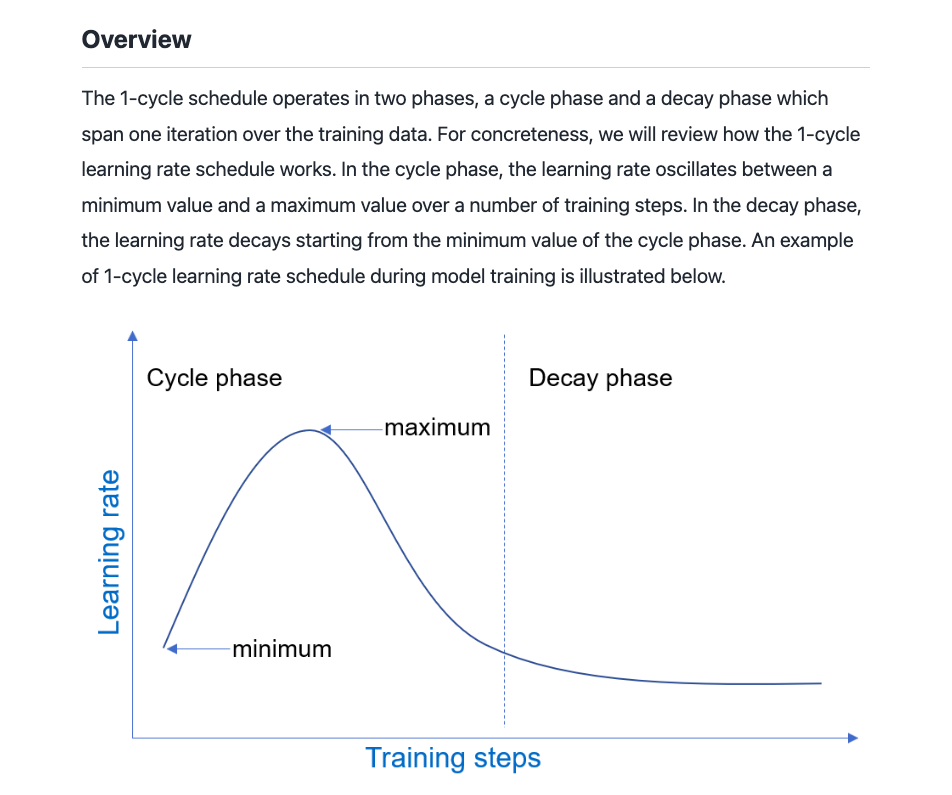

In [ ]:
plt.plot(rates)
plt.ylabel("Learning rate")
plt.xlabel("Iteration")

In [ ]:
iterations = math.ceil(len(X_train_scaled) / batch_size) * n_epochs
rates_first_half = rates[:int(iterations/2)]
rates_second_half = rates[int(iterations/2):]

plt.plot(rates[:380])
plt.ylabel("Learning rate")
plt.xlabel("Iteration")
plt.title('Iterations Start-400')

In [ ]:
plt.plot(rates[400:3000])
plt.ylabel("Learning rate")
plt.xlabel("Iteration")
plt.title('Iterations 400-3000') # ax rate e çıktı

In [ ]:
plt.plot(rates[3000:5100])
plt.ylabel("Learning rate")
plt.xlabel("Iteration")
plt.title('Iterations 3000- 5100') 

In [ ]:
plt.plot(rates[5000:])
plt.ylabel("Learning rate")
plt.xlabel("Iteration")
plt.title('Iteartions 5000 - End, Decay Phase') 

In [ ]:
model = keras.models.load_model("my_cifar10_1cycle_model.h5")
model.evaluate(X_valid_scaled, y_valid)

* One cycle allowed us to train the model in just 15 epochs, each taking only 6 seconds (thanks to the larger batch size). This is several times faster than the fastest model we trained so far. Moreover, we improved the model's performance (from 46.08% to 47.76%). The batch normalized model reaches a slightly better performance (54.22%), but it's much slower to train.

## Links

* https://github.com/ageron/handson-ml2/blob/master/11_training_deep_neural_networks.ipynb